CS573100 Music Information Retrieval

DDL: 2023.5.9.

Description: Homework 2. Intrument and pitch classification.

Requirements:
1. Name you file as HW2_{student-id}.ipynb and submit to eeclass.
2. Strongly recommend writing the report on your jupyter notebook file.

### 1. Explain meaning of TinySol1 dataset’s track ID annotation

**Track ID: Cb-ord-A2-ff-1c-R100d**
* The track ID follows the format (INSTR)-ord-(PITCH)-(DYN)-(INSTANCE)-(MISC) where
    * INSTR is the abbreviation of the instrument
    * ord is the abbreviation for ordinario (the ordinary playing technique)
    * PITCH denotes the pitch of the musical note
    * DYN denotes the intensity dynamics, ranged from pp to ff
    * INSTANCE denotes additional information about the instrument being played
        * For bowed instruments, 1c, 2c, 3c, 4c denotes which string is being bowed
        * For wind instruments, alt1, alt2, denotes alternative instances of the note if the same note is played multiple times
        * N for not applicable
    * MISC denotes additional info
        * R stands for resampled, denotes that it is obtained by transforming a different audio clip
        * T stands for tuned, Because some pitches are out of tune
        * N for natural, meaning the note is distributed as it was recorded
* So this example corresponds to 
    * a contrabass sound
    * played in the ordinary playing technique
    * at pitch A2
    * with fortissimo dynamics
    * on the first string
    * resampled from a A#2 by lowering pitch by a semitone, i.e. 100 cents (R100d)

### 2. Find audio file and plot

### 2.5 Data preperation

In [1]:
import librosa

# Load TinySOL metadata
# Import mirdata library
import mirdata

# Initialize tinysol dat

tinysol_dataset = mirdata.initialize("tinysol")
# tinysol_dataset.download()
# Load tinysol metadata
tinysol_metadata = tinysol_dataset._metadata

#### Feature Extraction

In [31]:
import numpy as np
# Create empty lists to store MFCC features and labels
mfccs_list = []
instrument_list = []
pitch_list = []

# Iterate through all the tracks in the dataset
for track_id in tinysol_dataset.track_ids:
  
  # Load a track by its ID
  track = tinysol_dataset.track(track_id)

  # Print some track information
  # print("----------------------")
  # print("Track ID:", track.track_id)
  # print("Instrument name:", track.instrument_full)
  # print("Pitch class:", track.pitch)
  #print("Dynamics:", track.dynamics)

  # Load and play the audio file of the track
  audio, sr = track.audio
  #track.play_audio()

  # TODO:  IMPLEMENT FEATURE EXTRACTION
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=200)
  feat = np.average(mfcc, axis=1)
  # Append the MFCC features and labels to the lists
  mfccs_list.append(feat)
  instrument_list.append(track.instrument_full)
  pitch_list.append(track.pitch)

In [43]:
# Convert the lists to numpy arrays for tensorflow compatibility[^2^][2] [^3^][3]
mfccs_array = np.array(mfccs_list)
instrument_array = np.array(instrument_list)
pitch_array = np.array(pitch_list)

In [44]:
from sklearn import preprocessing

#### Split Training Set and Testing Set 

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_instrument, y_test_instrument, y_train_pitch, y_test_pitch = train_test_split(
    mfccs_array, instrument_array, pitch_array,test_size=0.2, random_state=23) # DON'T Modify Random_state!


In [64]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          size="small",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')
    
    if size == "small":
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    elif size == "large":
        plt.rcParams["figure.figsize"] = (20,15)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [57]:
def print_evaluation(ground_truth, pred):
    accuracy = accuracy_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred, average='micro') #can try other ave method
    precision = precision_score(ground_truth, pred, average='micro')
    print('ACC = ',  round(accuracy,3))
    print('precision = ', round(precision,3))
    print('recall = ', round(recall, 3))

In [58]:
from sklearn import preprocessing

### 3. Instrument Classification

In [49]:
instr_le = preprocessing.LabelEncoder()
instr_le.fit_transform(instrument_array)
instr_classes = instr_le.classes_

In [50]:
# Import scikit-learn library for SVM model and K-fold cross-validation
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold


# Create a model for Intstrument Classification
svm = SVC()
dt = DecisionTreeClassifier()
mlp = MLPClassifier()

# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

  # TODO: Train your model using the train subset
  svm.fit(X_train_kfold, y_train_kfold_instrument)
  dt.fit(X_train_kfold, y_train_kfold_instrument)
  mlp.fit(X_train_kfold, y_train_kfold_instrument)

  # TODO:　Evaluate your model  using the validation subset
  svm_score = accuracy_score(y_val_kfold_instrument, svm.predict(X_val_kfold))
  dt_score = accuracy_score(y_val_kfold_instrument, dt.predict(X_val_kfold))
  mlp_score = accuracy_score(y_val_kfold_instrument, mlp.predict(X_val_kfold))

  print("----------------")
  print("svm val score:", svm_score)
  print("dt val score:", dt_score)
  print("mlp val score:", mlp_score)

svm.fit(X_train, y_train_instrument)
dt.fit(X_train, y_train_instrument)

# TODO: Evaluate your model using the test set
svm_score = accuracy_score(y_test_instrument, svm.predict(X_test))
dt_score = accuracy_score(y_test_instrument, dt.predict(X_test))
mlp_score = accuracy_score(y_test_instrument, mlp.predict(X_test))

print("-----------------")
print("svm test score:", svm_score)
print("dt test score:", dt_score)
print("mlp test sccore", mlp_score)

----------------
svm val score: 0.6580976863753213
dt val score: 0.7737789203084833
mlp val score: 0.8894601542416453
----------------
svm val score: 0.6375321336760925
dt val score: 0.7455012853470437
mlp val score: 0.9177377892030848
----------------
svm val score: 0.6443298969072165
dt val score: 0.7525773195876289
mlp val score: 0.8943298969072165
----------------
svm val score: 0.6829896907216495
dt val score: 0.8067010309278351
mlp val score: 0.9201030927835051
----------------
svm val score: 0.6211340206185567
dt val score: 0.7989690721649485
mlp val score: 0.8943298969072165
----------------
svm val score: 0.634020618556701
dt val score: 0.7319587628865979
mlp val score: 0.8917525773195877
-----------------
svm test score: 0.6638078902229846
dt test score: 0.7941680960548885
mlp test sccore 0.9176672384219554


---- svm evaluation ----
ACC =  0.664
precision =  0.664
recall =  0.664
Confusion matrix


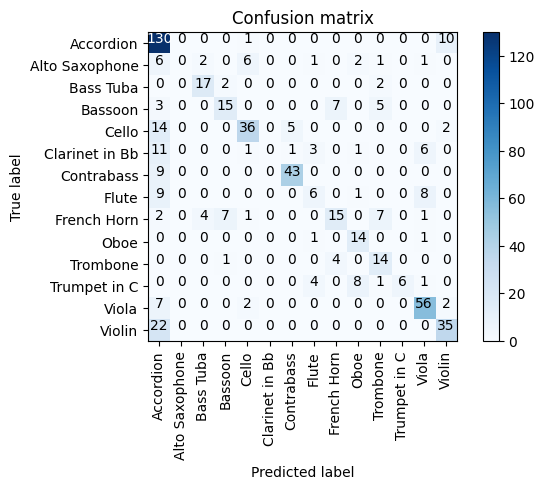

---- decision tree evaluation ----
ACC =  0.794
precision =  0.794
recall =  0.794
Confusion matrix


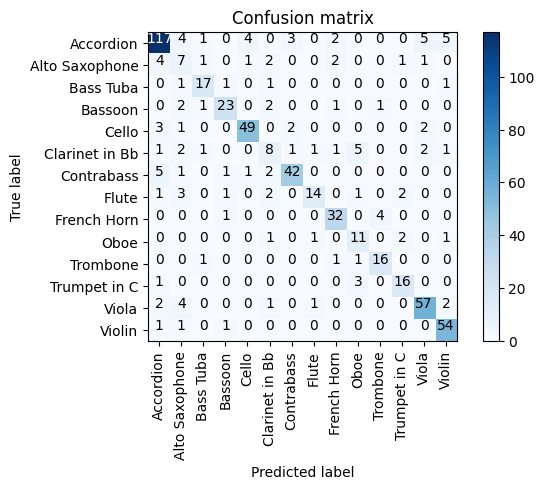

---- mlp evaluation ----
ACC =  0.918
precision =  0.918
recall =  0.918
Confusion matrix


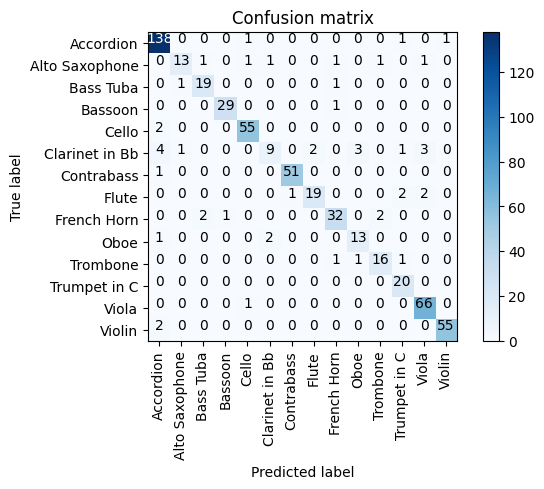

In [59]:
print("---- svm evaluation ----")
predicts = svm.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

print("---- decision tree evaluation ----")
predicts = dt.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

print("---- mlp evaluation ----")
predicts = mlp.predict(X_test)
print_evaluation(y_test_instrument, predicts)
plot_confusion_matrix(confusion_matrix(y_test_instrument, predicts) , instr_classes)

#### Discussion/Observation
* The performance on the instrument classification tasks MLP > Decision Tree > SVM
* The reason is

### 4. Pitch Classification

In [53]:
pitch_le = preprocessing.LabelEncoder()

pitch_array = pitch_le.fit_transform(pitch_array)
pitch_classes = pitch_le.classes_
print(pitch_classes)

['A#1' 'A#2' 'A#3' 'A#4' 'A#5' 'A#6' 'A#7' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6'
 'A7' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'C#2' 'C#3' 'C#4' 'C#5' 'C#6'
 'C#7' 'C#8' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'D#2' 'D#3' 'D#4' 'D#5'
 'D#6' 'D#7' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'E1' 'E2' 'E3' 'E4' 'E5' 'E6'
 'E7' 'F#1' 'F#2' 'F#3' 'F#4' 'F#5' 'F#6' 'F#7' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'G#1' 'G#2' 'G#3' 'G#4' 'G#5' 'G#6' 'G#7' 'G1' 'G2' 'G3' 'G4'
 'G5' 'G6' 'G7']


In [54]:
# Create a model for Pitch Classification
svm_pitch = SVC()
dt_pitch = DecisionTreeClassifier()
mlp_pitch = MLPClassifier()


# Perform K-fold cross-validation 
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]

  # TODO: Train your model using the train subset
  svm_pitch.fit(X_train_kfold, y_train_kfold_pitch)
  dt_pitch.fit(X_train_kfold, y_train_kfold_pitch)
  mlp_pitch.fit(X_train_kfold, y_train_kfold_pitch)

  # TODO:　Evaluate your model  using the validation subset
  svm_score = accuracy_score(y_val_kfold_pitch, svm_pitch.predict(X_val_kfold))
  dt_score = accuracy_score(y_val_kfold_pitch, dt_pitch.predict(X_val_kfold))
  mlp_score = accuracy_score(y_val_kfold_pitch, mlp_pitch.predict(X_val_kfold))

  print("--------------")
  print("svm val score:", svm_score)
  print("dt val score:", dt_score)
  print("mlp val score:", mlp_score)

# TODO: Evaluate the model on the instrument label using the test set
svm_score = accuracy_score(y_test_pitch, svm_pitch.predict(X_test))
dt_score = accuracy_score(y_test_pitch, dt_pitch.predict(X_test))
mlp_score = accuracy_score(y_test_pitch, mlp_pitch.predict(X_test))

print("-----------------")
print("svm test score:", svm_score)
print("dt test score:", dt_score)
print("mlp test sccore", mlp_score)

--------------
svm val score: 0.7275064267352185
dt val score: 0.8508997429305912
mlp val score: 0.9691516709511568
--------------
svm val score: 0.7377892030848329
dt val score: 0.8457583547557841
mlp val score: 0.9537275064267352
--------------
svm val score: 0.711340206185567
dt val score: 0.8350515463917526
mlp val score: 0.961340206185567
--------------
svm val score: 0.6469072164948454
dt val score: 0.8376288659793815
mlp val score: 0.9639175257731959
--------------
svm val score: 0.7190721649484536
dt val score: 0.8376288659793815
mlp val score: 0.9664948453608248
--------------
svm val score: 0.7190721649484536
dt val score: 0.8324742268041238
mlp val score: 0.9690721649484536
-----------------
svm test score: 0.758147512864494
dt test score: 0.8662092624356775
mlp test sccore 0.9794168096054888


---- svm pitch eval ----
ACC =  0.758
precision =  0.758
recall =  0.758
Confusion matrix


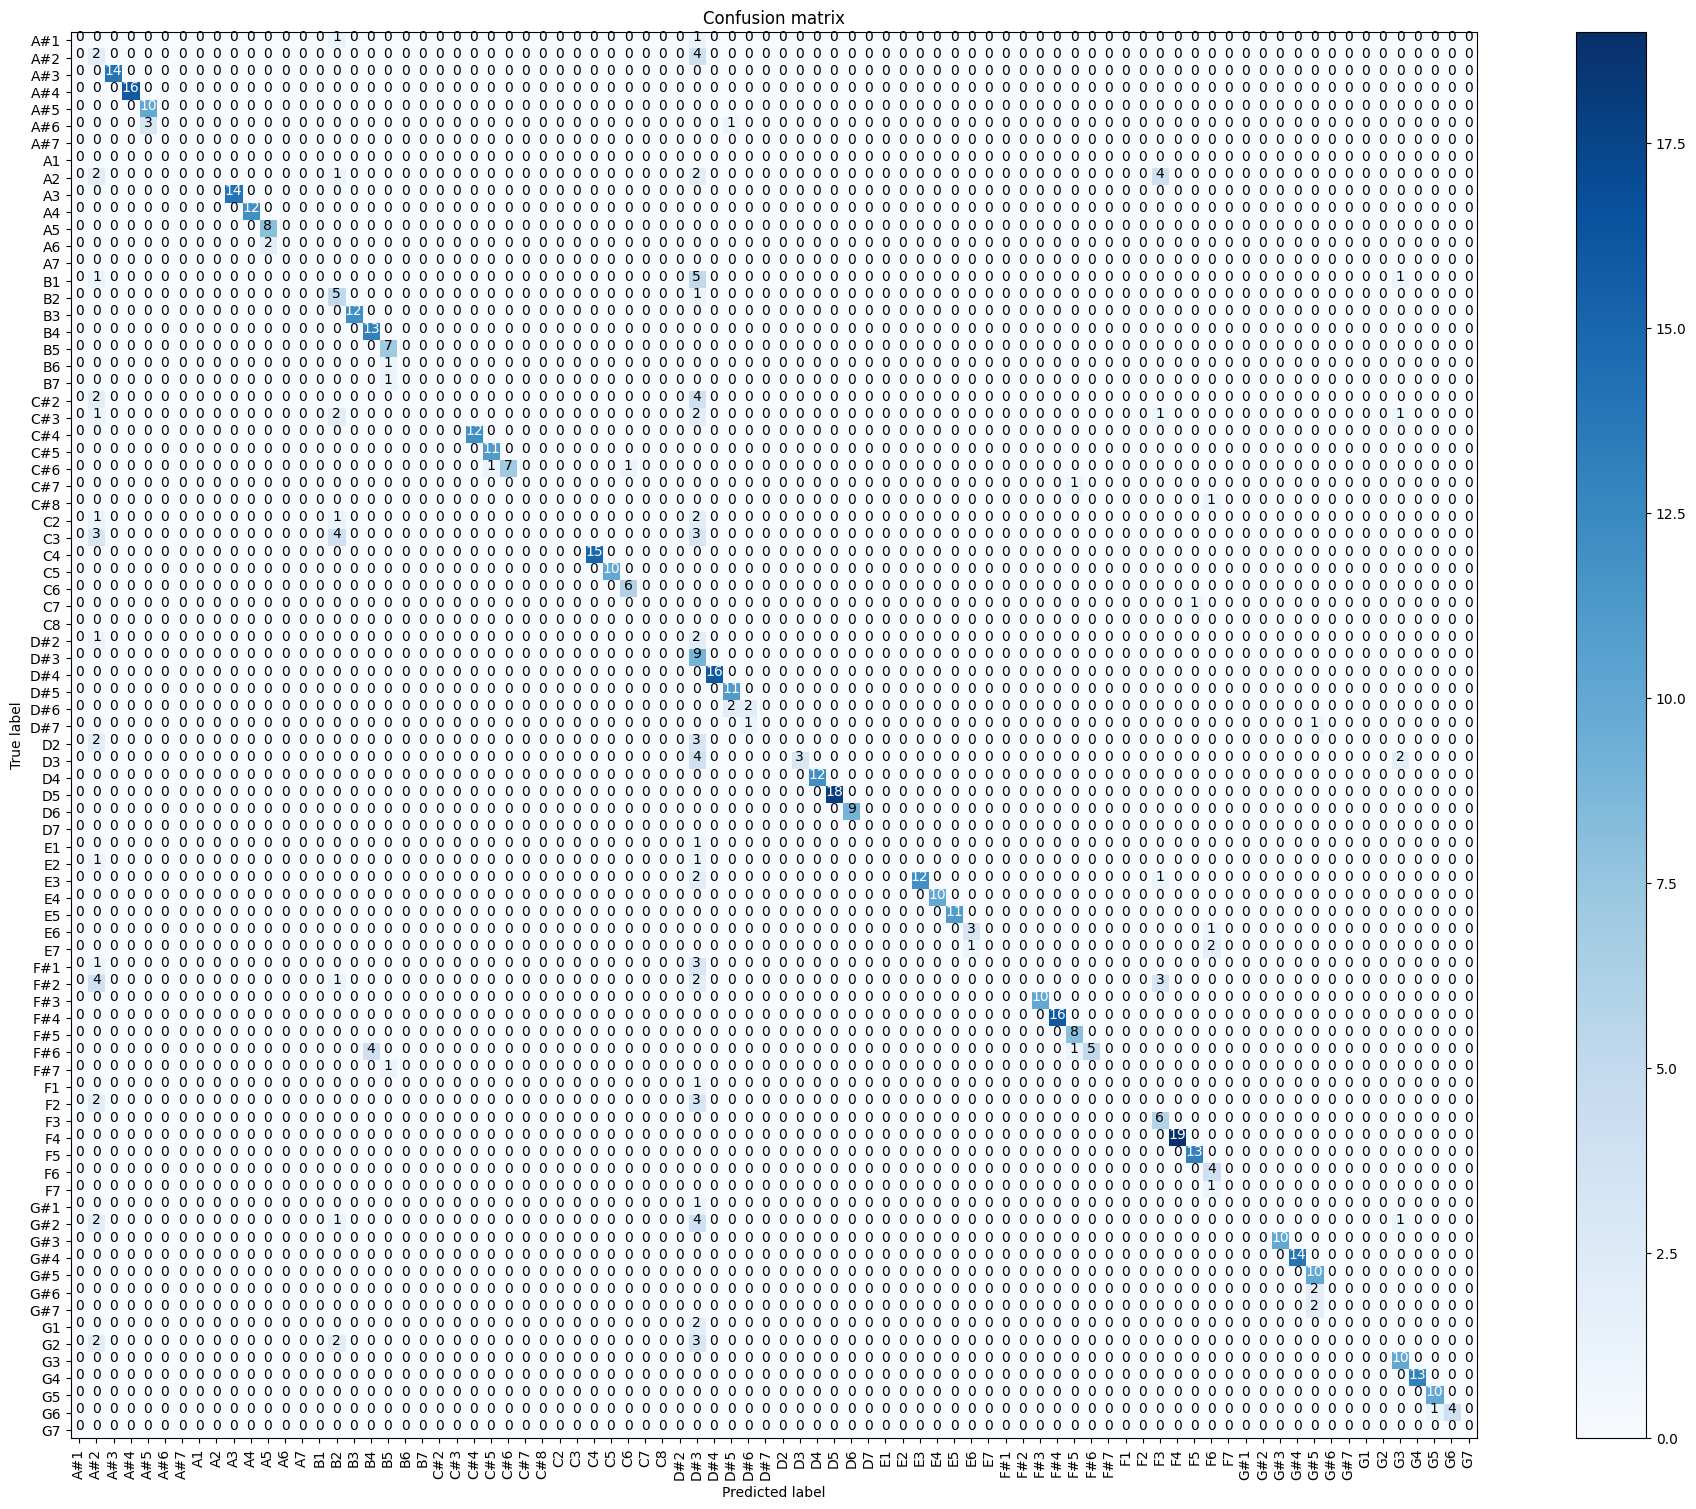

---- dt pitch eval ----
ACC =  0.866
precision =  0.866
recall =  0.866
Confusion matrix


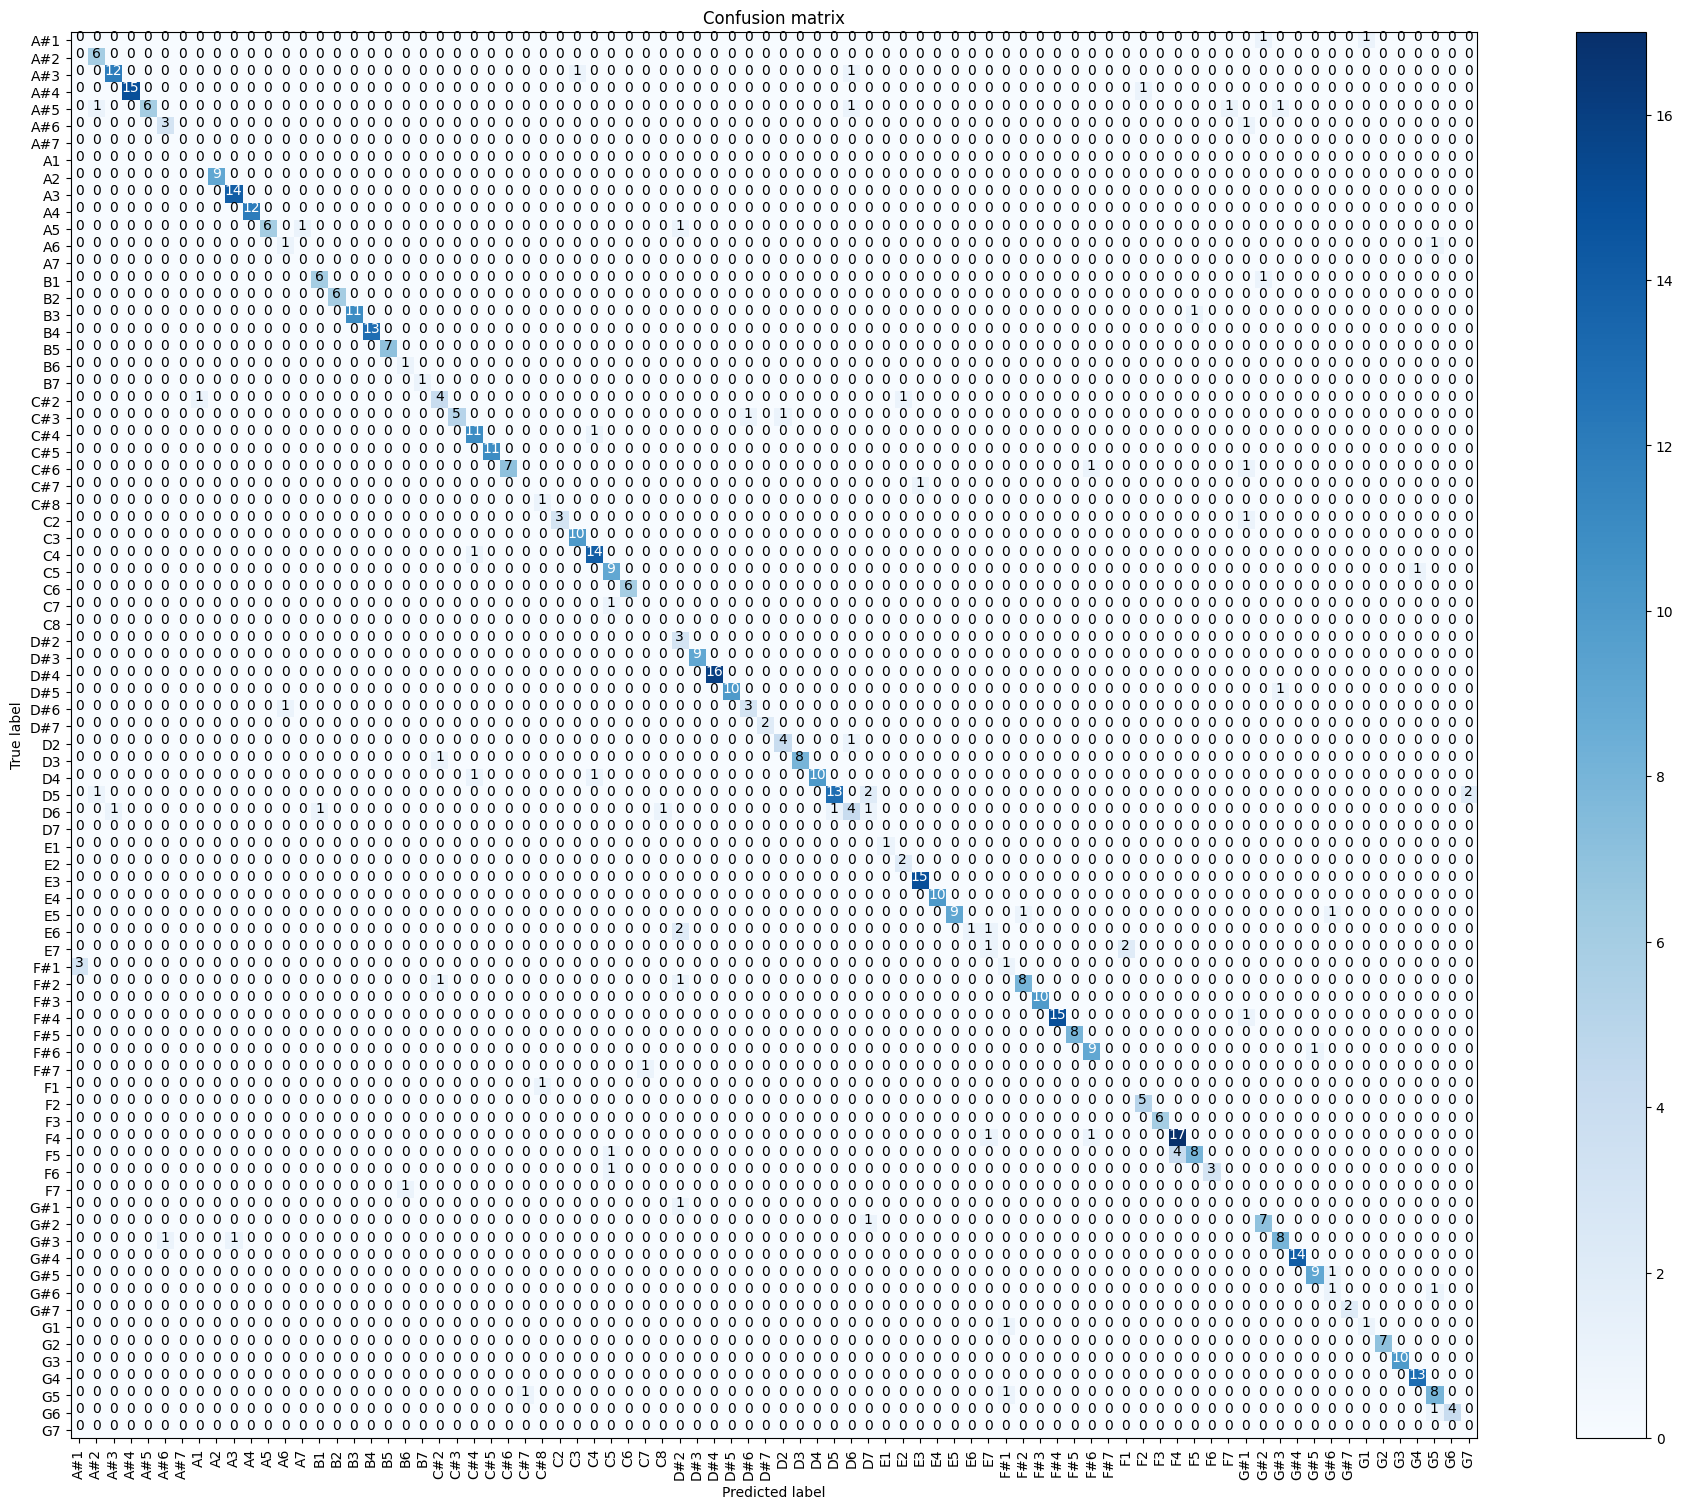

---- mlp pitch eval ----
ACC =  0.979
precision =  0.979
recall =  0.979
Confusion matrix


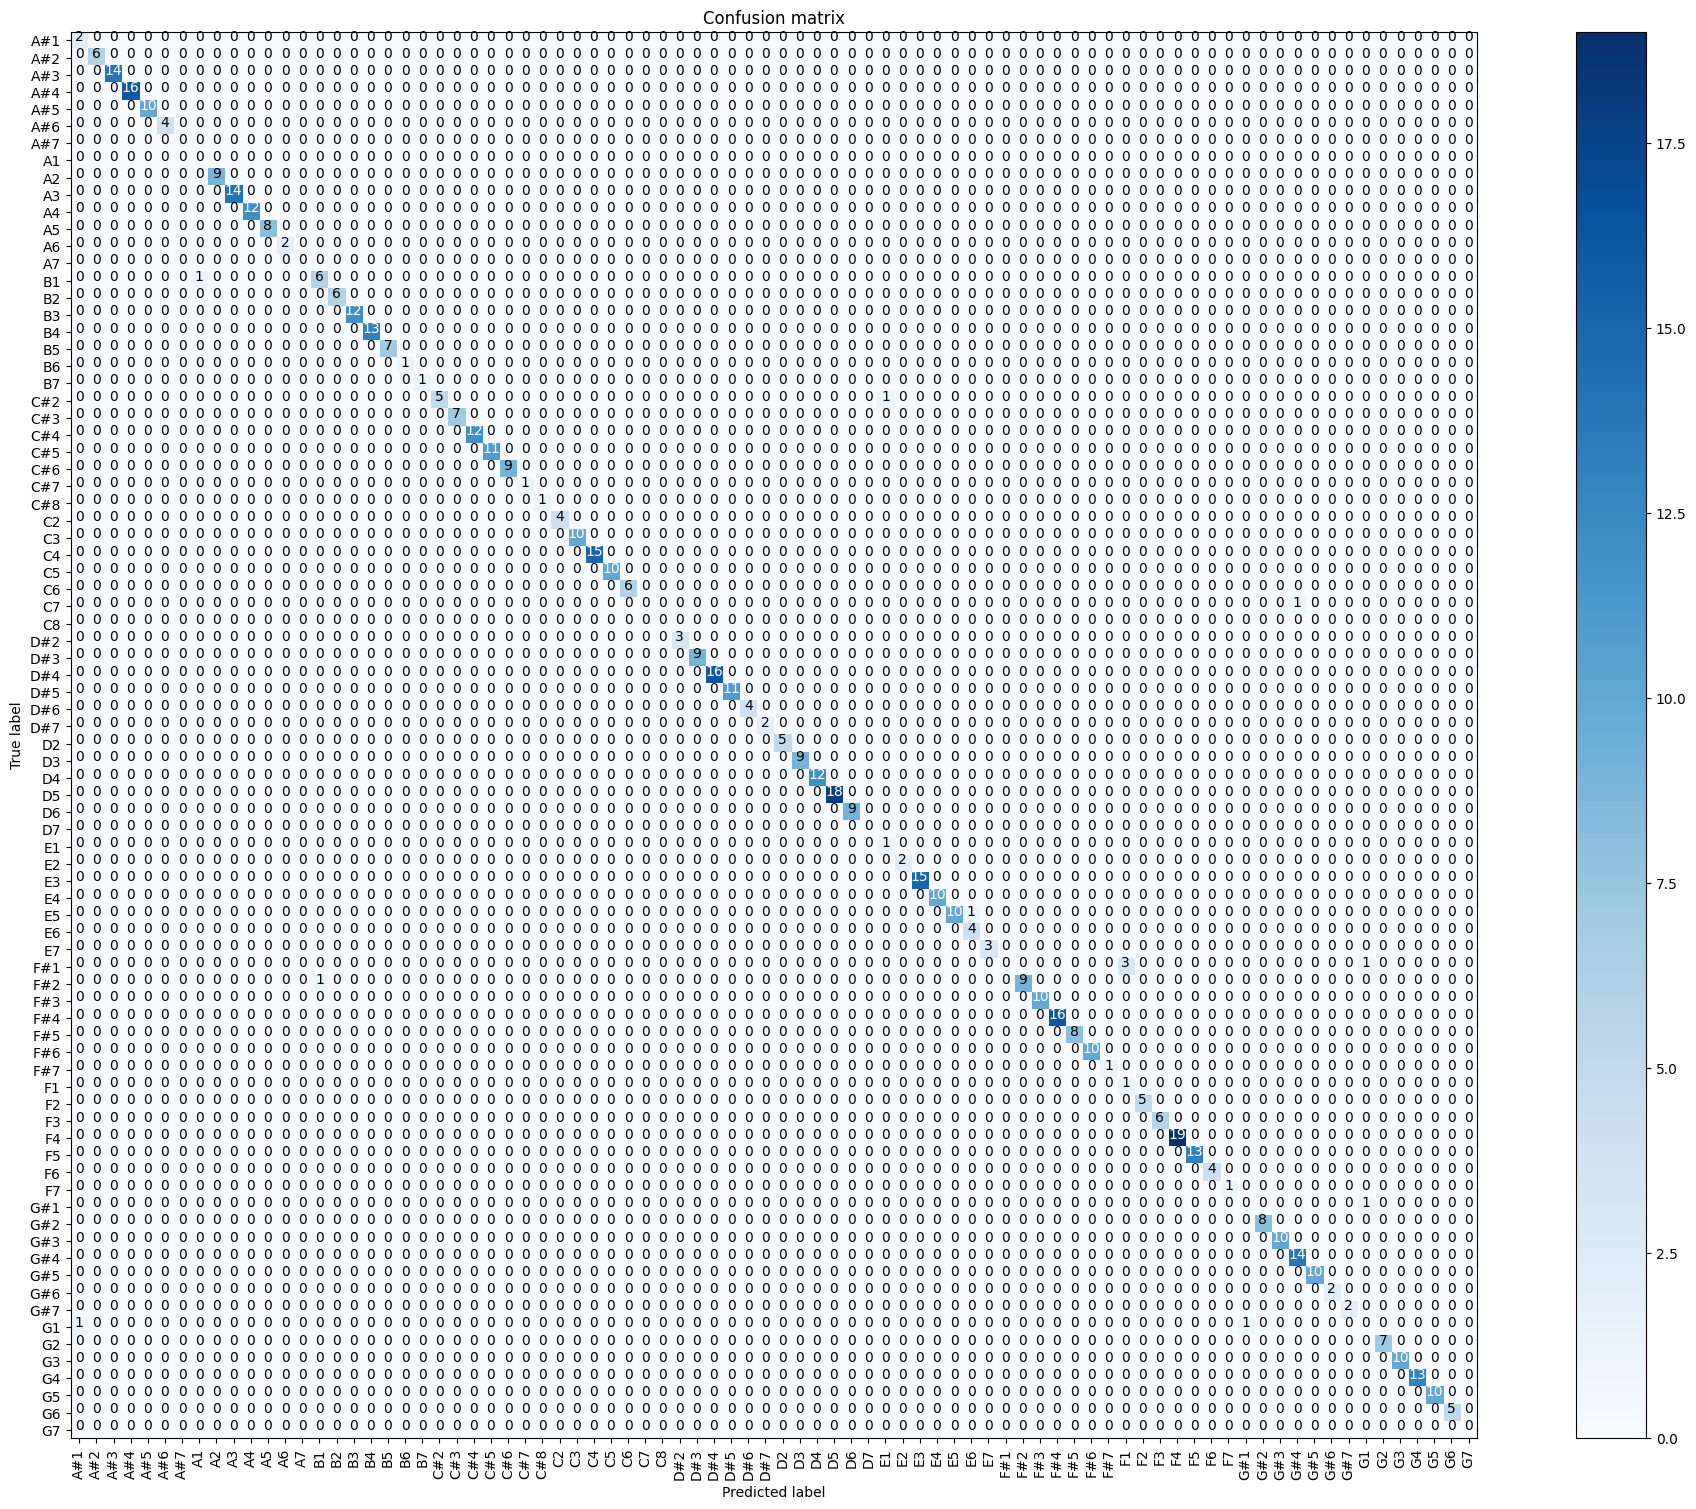

In [70]:
print("---- svm pitch eval ----")
predicts = svm_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) ,pitch_classes, size="large")

print("---- dt pitch eval ----")
predicts = dt_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) , pitch_classes,  size="large")

print("---- mlp pitch eval ----")
predicts = mlp_pitch.predict(X_test)
print_evaluation(y_test_pitch, predicts)
plot_confusion_matrix(confusion_matrix(y_test_pitch, predicts, labels=pitch_classes) , pitch_classes,  size="large")

#### Discussion/Observation
* Performance MLP > Decision Tree > SVM
* Why? 

### 5. Grid search to find best hyperparameters